In [2]:
from lxml import etree
import os
from os import listdir
import pandas as pd
from IPython.display import display, HTML
from msgspec.json import decode

from torchvision.io import read_image
import matplotlib.pyplot as plt

In [3]:
class Defect:
    assemblyRevision = ''
    serialNumber = ''
    testerName = ''
    type = ''
    dataFolderName = ''
    indictmentType = ''
    repairOperator = ''
    repairStatus = ''
    designator = ''
    partId = ''
    pinId = ''

    def to_dict(self):
        res = {}
        res['assemblyRevision'] = self.assemblyRevision
        res['serialNumber'] = self.serialNumber
        res['testerName'] = self.testerName
        res['type'] = self.type
        res['dataFolderName'] = self.dataFolderName
        res['indictmentType'] = self.indictmentType
        res['repairOperator'] = self.repairOperator
        res['repairStatus'] = self.repairStatus
        res['designator'] = self.designator
        res['partId'] = self.partId
        res['pinId'] = self.pinId

        return res

In [4]:
def parse_file_for_defects(path, include_pin = True):
    root = etree.parse(path)
    ns = root.getroot().nsmap
    res = [] #Defect()
    serialNumber = root.getroot().find("ns1:BoardXML", ns).attrib.get('serialNumber')
    testerName = root.getroot().find("ns1:StationXML", ns).attrib.get('testerName')
    assemblyRevision = root.getroot().find("ns1:BoardXML", ns).attrib.get('assemblyRevision')
    dataFolderName = root.getroot().attrib.get('dataFolderName') 

    # TestXML = root.getroot().findall(".//ns1:TestXML", ns)
    TestXML = root.getroot().findall(".//ns1:TestXML", ns)
    for test in TestXML:
        name = test.attrib.get('name')
        IndictmentXML = test.findall(".//ns1:IndictmentXML", ns)
        PinXML = test.findall(".//ns1:PinXML", ns)
    
        for Indictment in IndictmentXML:
            tmp = Defect()
            tmp.assemblyRevision = assemblyRevision
            tmp.serialNumber = serialNumber
            tmp.testerName = testerName
            tmp.designator = name
            tmp.dataFolderName = dataFolderName
            tmp.type = 'IndictmentXML'
            tmp.indictmentType = Indictment.attrib.get('indictmentType')
            tmp.repairOperator = Indictment.find("ns1:RepairActionXML", ns).attrib.get('repairOperator')
            tmp.repairStatus = Indictment.find("ns1:RepairActionXML", ns).attrib.get('repairStatus')
            tmp.partId = Indictment.find("ns1:ComponentXML", ns).attrib.get('partId')
            res.append(tmp)

        if include_pin:
            partId = IndictmentXML[0].find("ns1:ComponentXML", ns).attrib.get('partId')
            repairOperator = IndictmentXML[0].find("ns1:RepairActionXML", ns).attrib.get('repairOperator')
            for pin in PinXML:
                repairStatus = pin.attrib.get('repairStatus')
                id = pin.attrib.get('id')
                PinIndictmentXML = pin.findall(".//ns1:PinIndictmentXML", ns)
                tmp.dataFolderName = dataFolderName

                for pinIndictment in PinIndictmentXML:
                    tmp = Defect()
                    tmp.assemblyRevision = assemblyRevision
                    tmp.serialNumber = serialNumber
                    tmp.testerName = testerName
                    tmp.designator = name
                    tmp.dataFolderName = dataFolderName
                    tmp.type = 'PinXML'
                    tmp.indictmentType = pinIndictment.attrib.get('indictmentType')
                    tmp.repairOperator = repairOperator
                    tmp.repairStatus = repairStatus
                    tmp.partId = partId
                    tmp.pinId = id
                    res.append(tmp)
        
    return res

In [5]:
def get_dataFolderName(path):
    root = etree.parse(path)
    dataFolderName = root.getroot().attrib.get('dataFolderName')
    return dataFolderName


def get_df_defects(file_path, include_pin):
    defects = []
    tmp = parse_file_for_defects(file_path, include_pin = include_pin)
    for t in tmp:
        defects.append(t.to_dict())

    df_defects = pd.DataFrame(defects)

    return df_defects


def get_img_df(img_folder):
    path_json = img_folder + 'json_data.json'

    with open(path_json, "rb") as f:
        data = decode(f.read())

    all_rows = data['post_ticket']['call_summary']['falsecall_refdes']
    all_rows.update(data['post_ticket']['call_summary']['truecall_refdes'])

    df_js = pd.DataFrame.from_dict(all_rows, orient='index')
    df_js.reset_index(inplace=True)
    df_js.rename(columns={'index': 'designator'}, inplace=True)
    df_js['img_folder'] = img_folder
    
    return df_js

In [6]:
XML_FILES_PATH = '/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/rawDATA/all-vvts-xml-marchonly/'
PATH_IMAGES = '/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/rawDATA/2024.03/'

In [7]:
all_xml_files = listdir(XML_FILES_PATH)
all_xml_files_full = [XML_FILES_PATH + file for file in all_xml_files]
all_xml_files_full.sort(key=os.path.getmtime)
len(all_xml_files_full), all_xml_files_full[:5]

(2439,
 ['/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/rawDATA/all-vvts-xml-marchonly/Y1MTB44B5Z05H#MBDX86742001B_T#V510#D-SMT-AOI-41#1#1709275967000#PostRepair#1709276669000.xml',
  '/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/rawDATA/all-vvts-xml-marchonly/Y1MTB44B5Z04Y#MBDX86742001B_T#V510#D-SMT-AOI-41#1#1709276531000#PostRepair#1709277423000.xml',
  '/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/rawDATA/all-vvts-xml-marchonly/Y1MTB44B5Z043#MBDX86742001B_T#V510#D-SMT-AOI-41#1#1709276393000#PostRepair#1709278238000.xml',
  '/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/rawDATA/all-vvts-xml-marchonly/Y1MTB44B5Z05I#MBDX86742001B_T#V510#D-SMT-AOI-41#1#1709276243000#PostRepair#1709281005000.xml',
  '/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/rawDATA/all-vvts-xml-marchonly/Y1MTB44BYF0BA#MBDX86742001B_T#V510#D-SMT-AOI-41#1#1709281218000#PostRepair#1709282671000.xml'])

In [8]:
valid_xml_files = []
nones = 0

for file in all_xml_files_full:
    tmp = get_dataFolderName(file)
    if tmp != None:
        # print(tmp, PATH_IMAGES + tmp.split('-')[-4] + '/' + tmp + '/json_data.json')
        if os.path.isfile(PATH_IMAGES + tmp.split('-')[-4] + '/' + tmp + '/json_data.json'):
            valid_xml_files.append(file)
    else:
        nones += 1
    
len(valid_xml_files), nones, nones*100/len(valid_xml_files), nones + len(valid_xml_files)

(2149, 261, 12.145183806421592, 2410)

In [9]:
valid_xml_files[:3]

['/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/rawDATA/all-vvts-xml-marchonly/Y1MTB44B5Z05H#MBDX86742001B_T#V510#D-SMT-AOI-41#1#1709275967000#PostRepair#1709276669000.xml',
 '/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/rawDATA/all-vvts-xml-marchonly/Y1MTB44B5Z04Y#MBDX86742001B_T#V510#D-SMT-AOI-41#1#1709276531000#PostRepair#1709277423000.xml',
 '/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/rawDATA/all-vvts-xml-marchonly/Y1MTB44B5Z043#MBDX86742001B_T#V510#D-SMT-AOI-41#1#1709276393000#PostRepair#1709278238000.xml']

In [42]:
list_df = []

for file_path in valid_xml_files:
    df_defects_tmp = get_df_defects(file_path, False)
    tmp = get_dataFolderName(file_path)
    df_img_tmp = get_img_df(PATH_IMAGES + tmp.split('-')[-4] + '/' + tmp + '/')
    df_total = df_defects_tmp.merge(df_img_tmp, on='designator', how='inner')
    list_df.append(df_total)

df_total_pre = pd.concat(list_df)
df_total_pre.describe()

,assemblyRevision,serialNumber,testerName,type,dataFolderName,indictmentType,repairOperator,repairStatus,designator,partId,pinId,defect_name,defect_image,img_folder
count,65488,65488,65488,65488,65488,65488,65488,65488,65488,65488,65488,65488,65488,65488
unique,12,1593,3,1,2148,22,7,2,2020,253,1,178,55521,2148
top,MPLSAS731005D_T,Y1MTB449MV001,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-12-22-05-12,BadJoint,Larisa_VVTS08,False Call,j87,0787280002,,[BadJoint],noImage,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
freq,33925,485,52427,65488,288,30643,34110,65020,858,24192,65488,27127,12,288


In [43]:
df_total_pre.loc[df_total_pre.repairStatus == 'False Call', 'repairStatus'] = 1
df_total_pre.loc[df_total_pre.repairStatus == 'Repaired', 'repairStatus'] = 0
df_total_pre.head()

,assemblyRevision,serialNumber,testerName,type,dataFolderName,indictmentType,repairOperator,repairStatus,designator,partId,pinId,defect_name,defect_image,img_folder
0,MBDX86742001B_T,Y1MTB44B5Z05H,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-01-09-53-26,OCV Fail,Svetlana_VVTS08,1,1:q68,BSC0906NSATMA1,,[OCV Fail],E_4509_1-q68.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
1,MBDX86742001B_T,Y1MTB44B5Z05H,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-01-09-53-26,OCV Fail,Svetlana_VVTS08,1,1:q67,BSC0906NSATMA1,,[OCV Fail],E_4509_1-q67.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
2,MBDX86742001B_T,Y1MTB44B5Z05H,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-01-09-53-26,Bridging,Svetlana_VVTS08,1,1:u139,TPS62130ARGTT,,[Bridging],E_4509_1-u139.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
3,MBDX86742001B_T,Y1MTB44B5Z05H,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-01-09-53-26,Bridging,Svetlana_VVTS08,1,1:y1,ABM8G-48_000MHZ-4Y-T3,,[Bridging],E_4509_1-y1.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
4,MBDX86742001B_T,Y1MTB44B5Z05H,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-01-09-53-26,Extra Part,Svetlana_VVTS08,1,1:u9,SN74LVC1G17DCKR,,[Extra Part],E_4509_1-u9.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...


In [44]:
df_total_pre['defect_image'].value_counts()

defect_image
noImage              12
E_4869_1-u283.jpg     7
E_4837_1-u163.jpg     7
E_031_r314.jpg        6
E_4665_1-u151.jpg     6
                     ..
E_386_j27.jpg         1
E_386_j16.jpg         1
E_386_j19.jpg         1
E_386_j22.jpg         1
E_4505_1-u133.jpg     1
Name: count, Length: 55521, dtype: int64

In [45]:
df_total_pre = df_total_pre[df_total_pre.defect_image != 'noImage']
df_total_pre.describe()

,assemblyRevision,serialNumber,testerName,type,dataFolderName,indictmentType,repairOperator,repairStatus,designator,partId,pinId,defect_name,defect_image,img_folder
count,65476,65476,65476,65476,65476,65476,65476,65476,65476,65476,65476,65476,65476,65476
unique,12,1593,3,1,2148,22,7,2,2018,252,1,178,55520,2148
top,MPLSAS731005D_T,Y1MTB449MV001,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-12-22-05-12,BadJoint,Larisa_VVTS08,1,j87,0787280002,,[BadJoint],E_4837_1-u163.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
freq,33925,485,52427,65476,288,30631,34110,65008,858,24192,65476,27115,7,288


In [12]:
df_total_pre.to_csv('df_total_pre.csv', index=False)

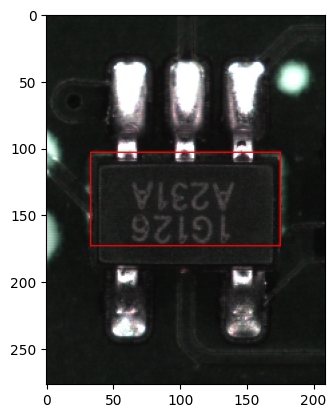

In [46]:
i = 55555
img_path = df_total_pre.iloc[i]['img_folder'] + df_total_pre.iloc[i]['defect_image']

img = read_image(img_path)
plt.imshow(  img.permute(1, 2, 0)  )

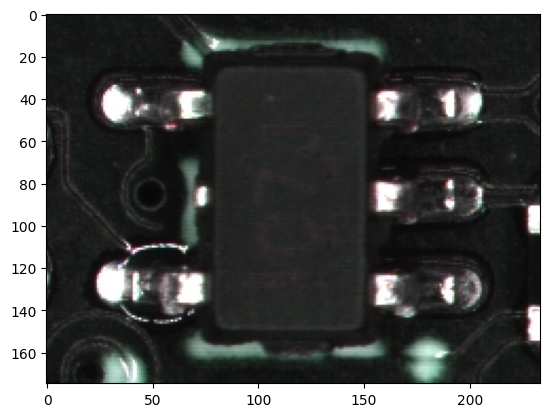

In [47]:
i = 555
img_path = df_total_pre.iloc[i]['img_folder'] + df_total_pre.iloc[i]['defect_image']

img = read_image(img_path)
plt.imshow(  img.permute(1, 2, 0)  )

In [48]:
df_total_false = df_total_pre.loc[df_total_pre['repairStatus'] == 1]
df_total_false.describe()

,assemblyRevision,serialNumber,testerName,type,dataFolderName,indictmentType,repairOperator,repairStatus,designator,partId,pinId,defect_name,defect_image,img_folder
count,65008,65008,65008,65008,65008,65008,65008,65008,65008,65008,65008,65008,65008,65008
unique,12,1593,3,1,2146,19,7,1,1944,248,1,174,55053,2146
top,MPLSAS731005D_T,Y1MTB449MV001,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-12-22-05-12,BadJoint,Larisa_VVTS08,1,j87,0787280002,,[BadJoint],E_4837_1-u163.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
freq,33695,485,52102,65008,287,30572,33930,65008,830,24188,65008,27057,7,287


In [50]:
65008 * 0.1 + 65008 * 0.75, 65008 * 0.75

(55256.8, 48756.0)

In [51]:
df_total_false_train = df_total_false[:48756]
df_total_false_val = df_total_false[48757:55257]
df_total_false_test = df_total_false[55258:]

In [52]:
df_total_true = df_total_pre.loc[df_total_pre['repairStatus'] == 0]
df_total_true.describe()

,assemblyRevision,serialNumber,testerName,type,dataFolderName,indictmentType,repairOperator,repairStatus,designator,partId,pinId,defect_name,defect_image,img_folder
count,468,468,468,468,468,468,468,468,468,468,468,468,468,468
unique,9,322,3,1,334,15,7,1,205,61,1,15,467,334
top,MPLSAS731005D_T,Y1F1D444W722H,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-12-13-11-47,Skew,Larisa_VVTS08,0,j84,MEC1-108-02-L-D-RA1-SL,,[Skew],E_1794_j85.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
freq,230,12,325,468,8,107,180,468,37,103,468,107,2,8


In [53]:
468 * 0.1 + 468 * 0.75, 468 * 0.75

(397.8, 351.0)

In [54]:
df_total_true_train = df_total_true[:350]
df_total_true_val = df_total_true[351:397]
df_total_true_test = df_total_true[398:]

In [55]:
df_total_train = pd.concat([df_total_false_train, df_total_true_train])
df_total_val = pd.concat([df_total_false_val, df_total_true_val])
df_total_test = pd.concat([df_total_false_test, df_total_true_test])

df_total_train.to_csv('df_total_train.csv', index=False)
df_total_val.to_csv('df_total_val.csv', index=False)
df_total_test.to_csv('df_total_test.csv', index=False)